<a href="https://colab.research.google.com/github/bcecil2/Deep-Learning-From-Scratch/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


In [ ]:
def conv3x3(inC,outC,stride=1,padding=1):
  return nn.Conv2d(inC,outC,3,stride=stride,padding=padding,bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
  def __init__(self,imChannels,numClasses,nLayers):
    super(ResNet,self).__init__()

    self.c1 = conv3x3(imChannels,16)
    self.b1 = nn.BatchNorm2d(16)
    self.l1 = self.makeLayers(nLayers[0],16,16,1)
    self.l2 = self.makeLayers(nLayers[1],16,32,2)
    self.l3 = self.makeLayers(nLayers[2],32,64,2)
    
    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.FC = nn.Linear(64,numClasses)
    self.sm = nn.Softmax(dim=1)
    # blocks 3,4,5 have stride of 2
  
  def forward(self,x):
    x = self.c1(x)
    x = self.b1(x)
    
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    
    x = self.pool(x)
    x = x.view(-1,64)
    x = self.FC(x)
    return self.sm(x)

  def makeLayers(self,n,inC,outC,stride):
    
    downSample = None
    if stride != 1:
      downSample = nn.Sequential(conv3x3(inC,outC,stride=stride),
                                 nn.BatchNorm2d(outC))
    
    layers = []
    layers.append(ResidualBlock(inC,outC,stride=stride,downsample=downSample))
    for i in range(n-1):
      layers.append(ResidualBlock(outC,outC))
    
    return nn.Sequential(*layers)


torch.Size([4, 3, 32, 32])
tensor([1, 2, 3, 2])


In [ ]:
from torchsummary import summary
R = ResNet(3,10,[9,9,9])
R = R.cuda()
summary(R, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
              ReLU-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
     ResidualBlock-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
             ReLU-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def s(h,w,p,k,s):
  nh = ((h + 2*p - (k-1)-1)/s) + 1
  nw = ((w + 2*p - (k-1)-1)/s) + 1
  return nh,nw


print(s(32,32,1,3,2))

(16.5, 16.5)


In [ ]:
transform = transforms.Compose(
    [
     transforms.Pad(4),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32),
     transforms.ToTensor()])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

epochs = 50
learning_rate = 0.001
crit = nn.CrossEntropyLoss()
optim = torch.optim.Adam(R.parameters(), lr=learning_rate, weight_decay=0.0001)


for epoch in range(epochs):
  for i,(img,l) in enumerate(trainloader):
    optim.zero_grad()
    img = img.to(device)
    l = l.to(device)
    out = R(img)
    loss = crit(out,l)
    loss.backward()
    optim.step()

    if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, epochs, i+1, 379, loss.item()))
    


Epoch [1/50], Step [100/379] Loss: 2.1848
Epoch [1/50], Step [200/379] Loss: 2.1060
Epoch [1/50], Step [300/379] Loss: 2.1012
Epoch [2/50], Step [100/379] Loss: 2.0679
Epoch [2/50], Step [200/379] Loss: 2.1730
Epoch [2/50], Step [300/379] Loss: 2.0633
Epoch [3/50], Step [100/379] Loss: 2.0595
Epoch [3/50], Step [200/379] Loss: 2.0030
Epoch [3/50], Step [300/379] Loss: 2.0603
Epoch [4/50], Step [100/379] Loss: 1.9824
Epoch [4/50], Step [200/379] Loss: 1.9124
Epoch [4/50], Step [300/379] Loss: 1.9619
Epoch [5/50], Step [100/379] Loss: 1.9376
Epoch [5/50], Step [200/379] Loss: 1.8361
Epoch [5/50], Step [300/379] Loss: 1.8338
Epoch [6/50], Step [100/379] Loss: 1.9037
Epoch [6/50], Step [200/379] Loss: 1.9186
Epoch [6/50], Step [300/379] Loss: 1.8812
Epoch [7/50], Step [100/379] Loss: 1.8279
Epoch [7/50], Step [200/379] Loss: 1.8464
Epoch [7/50], Step [300/379] Loss: 1.7968
Epoch [8/50], Step [100/379] Loss: 1.8058
Epoch [8/50], Step [200/379] Loss: 1.8385
Epoch [8/50], Step [300/379] Loss:

[2.1278464794158936, 2.080531120300293, 2.103219747543335, 2.1259756088256836, 2.116584300994873, 2.151034116744995, 2.1384544372558594, 2.1436803340911865, 2.133341073989868, 2.1002864837646484]


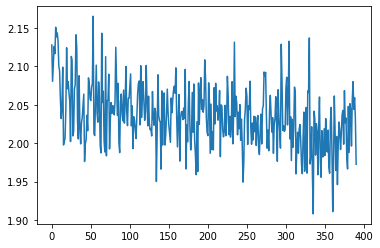

In [ ]:
import matplotlib.pyplot as plt
print(losses[:10])
plt.plot(losses)

In [ ]:
R.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = R(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(R.state_dict(), 'resnet.ckpt')

Accuracy of the model on the test images: 81.63 %


In [ ]:
397*100

39700